## 독립변수에 범주형 데이터가 있을 때

In [ ]:
import torch
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.datasets import load_boston
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler



# # GPU 설정 : 런타임 > 런타임 유형 변경 > GPU
# # GPU 사용 가능한지 확인
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# 특정파일을 가져오고 싶은 경우 다음과 같이 접근한다.
bst=load_boston()
dir(bst)
bst

In [ ]:
# 데이터 프레임 형태로 가공
bst_data=pd.DataFrame(data=bst.data,columns=bst.feature_names)
bst_target=pd.DataFrame(data=bst.target,columns=["House_Price_Mediv"]) 
bst_all=pd.concat([bst_data,bst_target],axis=1)
bst_all.describe()

In [ ]:
# CHAS 변수는 찰스강 근처에 위치했는지 여부를 표시한 변수
# 최소값 0, 최대값 1인데 4분위도 다 0이라 더미 변수인지 확인
bst_all["CHAS"].unique()

In [ ]:
# ## 스케일링
bst_scale=StandardScaler().fit_transform(bst_all)
bst_scale=pd.DataFrame(data=bst_scale,index=bst_all.index,columns=bst_all.columns)
bst_scale["CHAS"].unique()
bst_all=bst_scale

## 풀랭크 방식 (Full-Rank)

더미변수와 상수항을 더한 절편을 사용하는 경우
풀랭크(full-rank) 방식에서는 더미변수의 값을 원핫인코딩(one-hot-encoding) 방식으로 지정한다. 즉 범주값이 2가지인 경우에는

x1=A→d1A=1,d1B=0

x1=B→d1A=0,d1B=1이 된다. 

이 값을 대입하면 더미변수의 가중치는 상수항이 된다.

x1=A→y^=w1A+w2x2+⋯+wDxD

x1=B→y^=w1B+w2x2+⋯+wDxD

위 수식은 
x1=A인 데이터에 대해서는 y^=w1A+w2x2+⋯+wDxD 모형을 사용하고 

x1=B인 데이터에 대해서는 y^=w1B+w2x2+⋯+wDxD 모형을 사용하게 된다는 뜻이다. 

이렇게 하면 범주값이 달라졌을 때 상수항만 달라지고 다른 독립변수의 가중치(영향)는 같은 모형이 된다.

In [ ]:
# CHAS 변수를 절편으로 하는 더미 회귀식 만들기
## 절편이 1인 model
feature_names = list(bst.feature_names)
dummy_model1=sm.OLS.from_formula("House_Price_Mediv ~ 0 +" + "+".join(feature_names),
                                 data=bst_all)
result=dummy_model1.fit()
print(result.summary())

## 축소 랭크 방식 (Reduced-Rank)

축소랭크(reduced-rank) 방식에서는 특정한 하나의 범주값을 기준값(reference, baseline)으로 하고 기준값에 대응하는 더미변수의 가중치는 항상 1으로 놓는다. 

다른 범주형 값을 가지는 경우는 기준값에 추가적인 특성이 있는 것으로 간주한다. 예를 들어 다음 축소랭크 방식은 x1=A를 기준값으로 하는 경우이다.

x1=A → d1A=1,d1B=0

x1=B → d1A=0,d1B=1

반대로 x1=B를 기준값으로 하면 다음과 같아진다.

x1=A → d1A=1,d1B=1

x1=B → d1A=0,d1B=1

이 값을 대입하면 기준값인 더미변수의 가중치는 상수항이 되고 나머지 더미변수의 가중치는 그 상수항에 추가적으로 더해지는 상수항이 된다. x1=A를 기준값으로 하는 경우에는 다음과 같다.

x1=A → y^=w1A→y^=w1A+w1B+w2x2+⋯+wDxD

x1=B → y^=w1A+w1B+w2x2+⋯+wDxD+w2x2+⋯+wDxD

In [ ]:
# CHAS 변수를 절편으로 하는 더미 회귀식 만들기
## 절편이 1인 model
feature_names = list(bst.feature_names)
feature_names.remove("CHAS")
feature_names=[name for name in feature_names]+["C(CHAS)"]
print(feature_names)
dummy_model1=sm.OLS.from_formula("House_Price_Mediv ~ 0 +" + "+".join(feature_names),
                                 data=bst_all)
result=dummy_model1.fit()
print(result.summary())

### 두 개 이상의 범주형 변수가 있는 경우
두 개 이상의 범주형 변수가 있는 경우에는 축소형 방식을 사용한다. 이 때 주의할 점은 모든 범주형 범수의 가중치는 기준값 상수항에 더해지는 상수항으로 취급된다.

예들 들어 x1은 A, B 의 두가지 값을 가지고 x2은 X, Y의 두가지 값을 가지고 값을 가지는 경우 상수항과 각 더미변수의 가중치의 의미는 다음과 같아진다.

wAX : 기준값 x1=A, x2=X인 경우의 상수항

w1,B: 기준값 x1=B, x2=X인 경우에 추가되는 상수항

w1,Y: 기준값 x1=A, x2=Y인 경우에 추가되는 상수항

w1,B+w1,Y: 기준값 x1=B, x2=Y인 경우에 추가되는 상수항




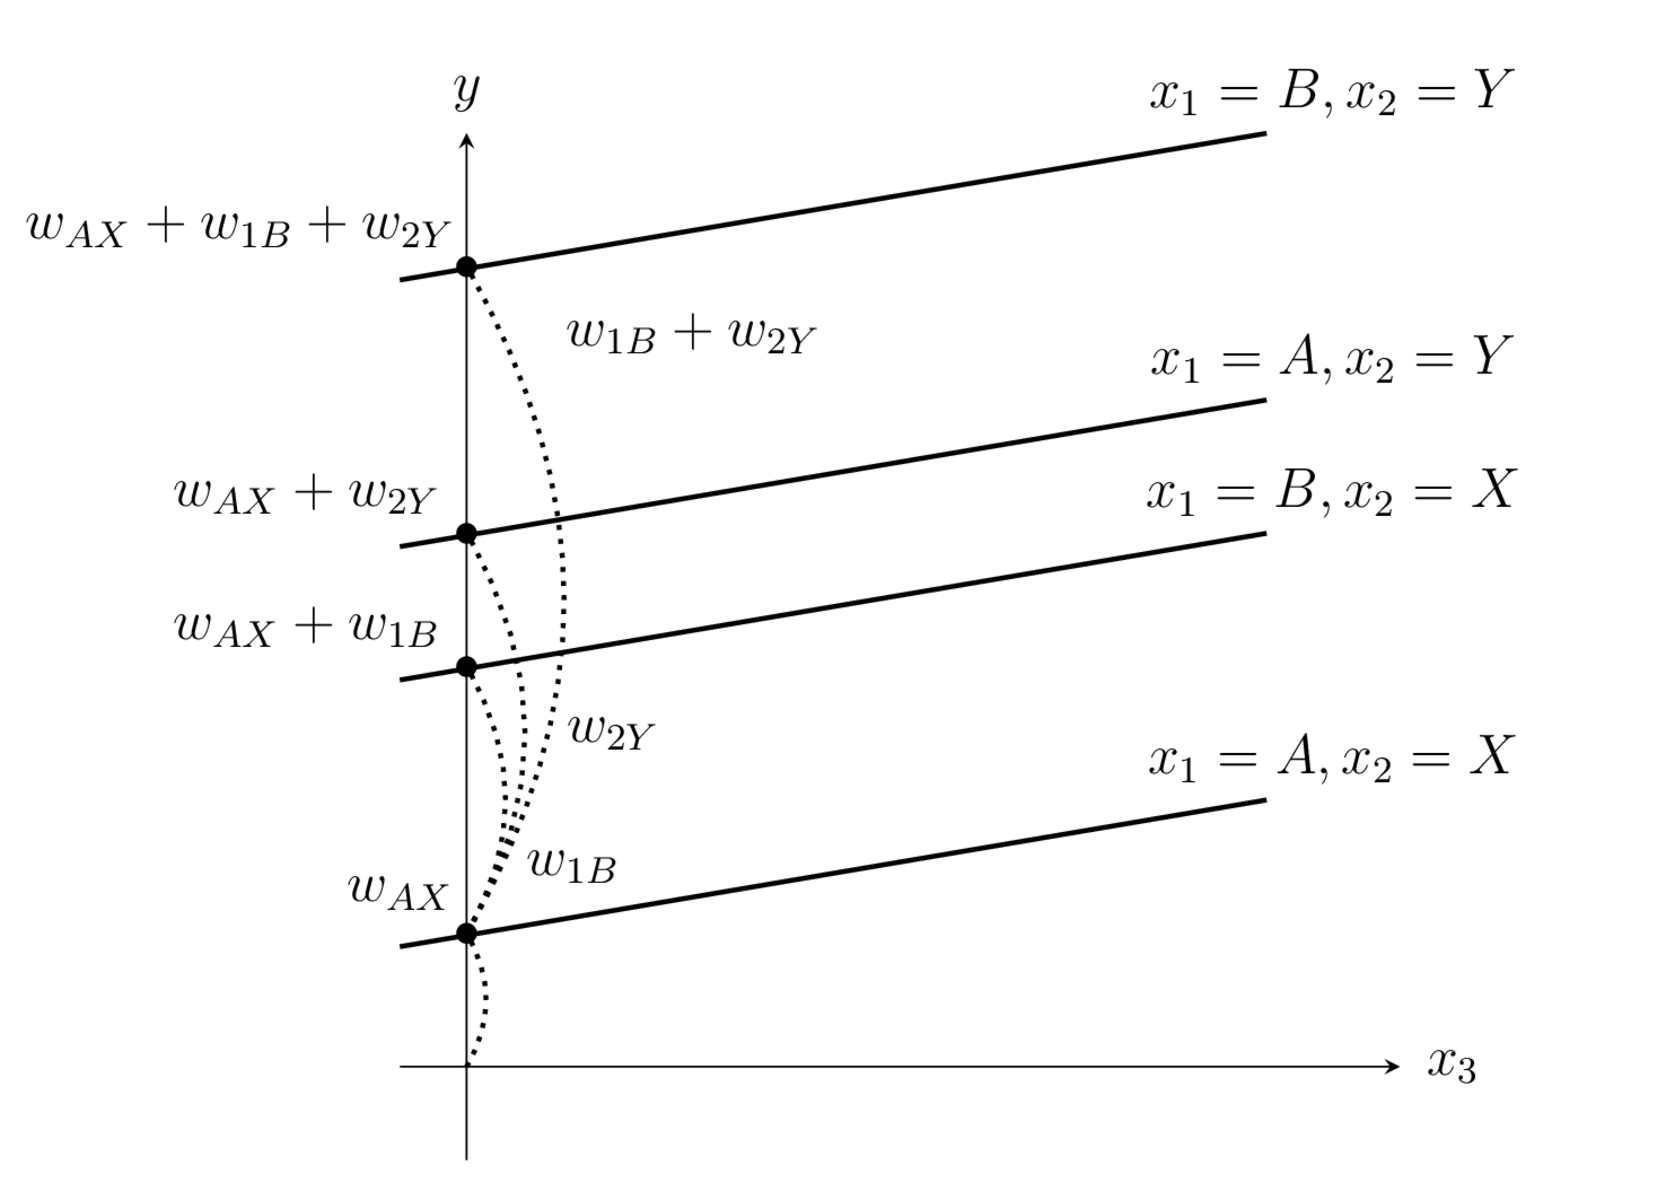

### 범주형 독립변수와 실수 독립변수의 상호작용
만약 범주형 변수의 값이 달라질 때 상수항만 달라지는 것이 아니라 다른 독립변수들이 미치는 영향도 달라지는 모형을 원한다면 상호작용(interaction)을 쓰면 된다. 예를 들어 범주형 독립변수 x1과 실수 독립변수 x2를 가지는 회귀모형에서 연속값 독립변수 x2가 미치는 영향 즉 가중치가 범주형 독립변수 x1의 값에 따라 달라진다면 범주형 독립변수를 더미변수 d1으로 인코딩하고 연속값 독립변수 x2는 d1과의 상호작용 항 d_1:x_2 를 추가하여 사용한다.


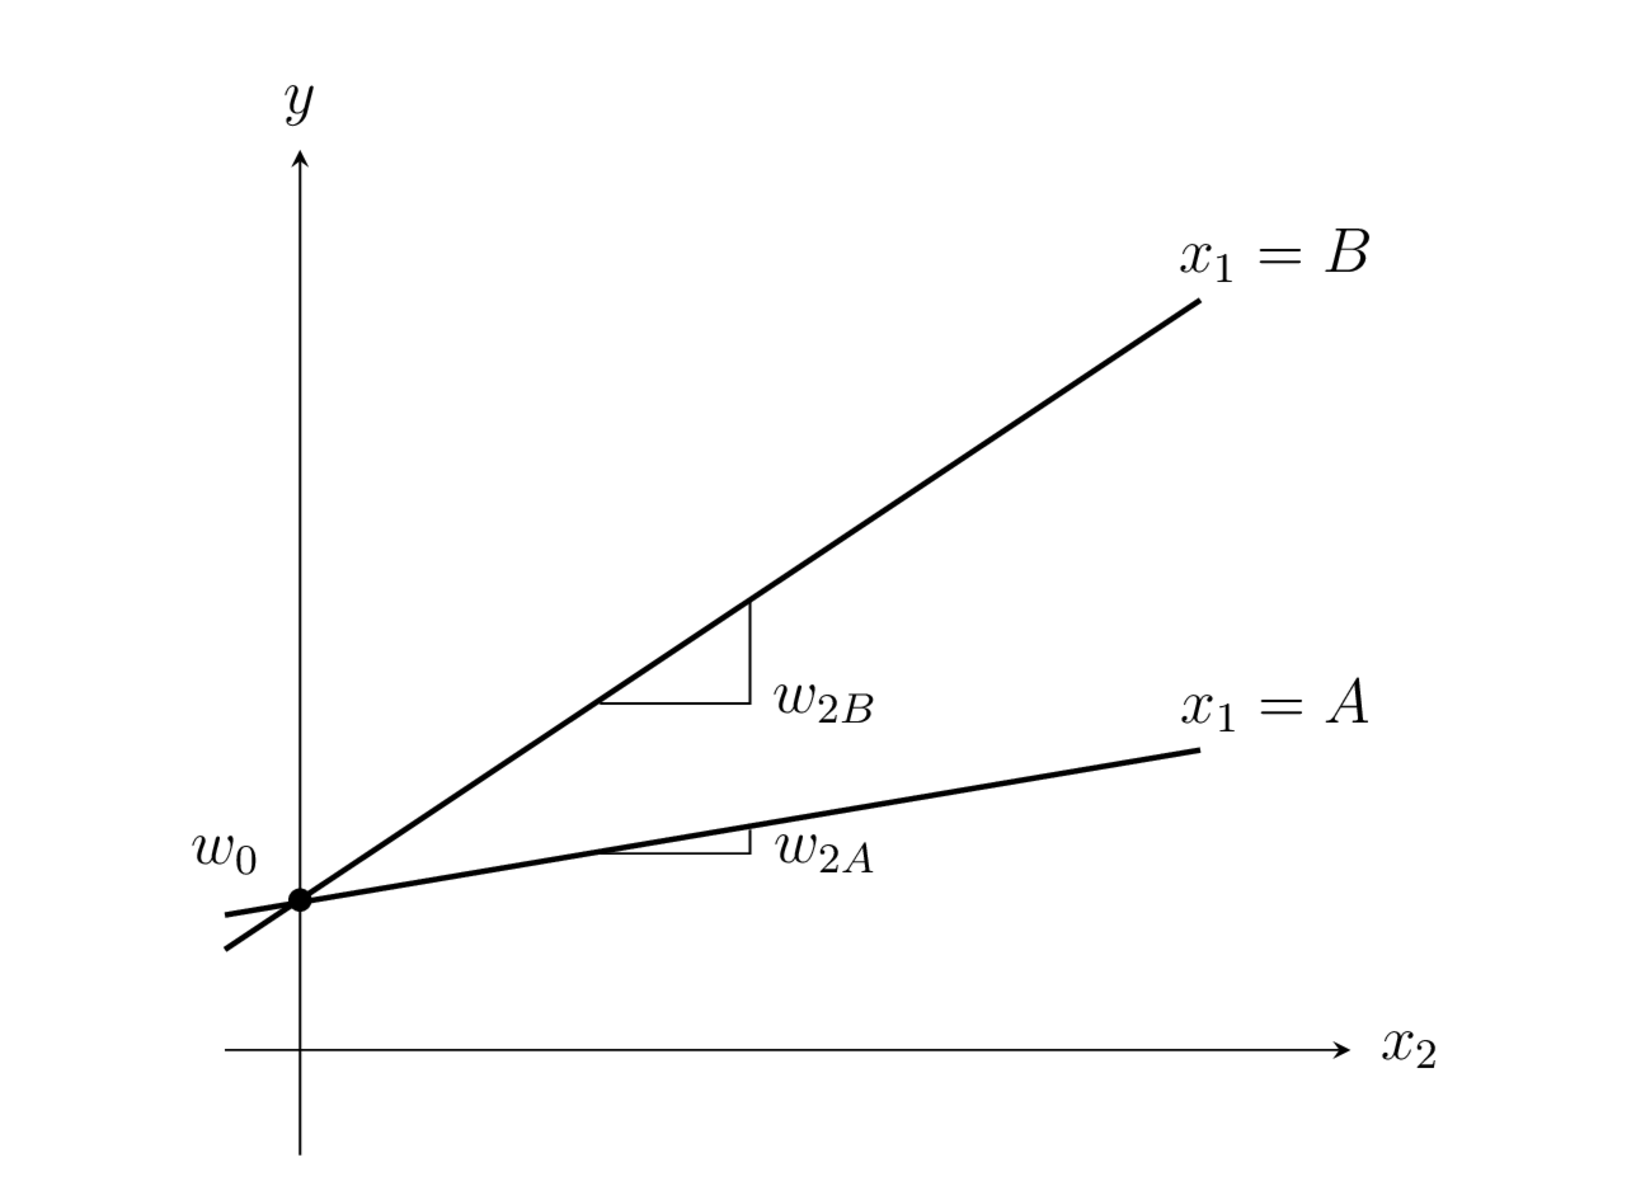



만약 범주형 독립변수도 종속변수에 영향을 미치고 범주형 독립변수와 실수 독립변수의 상호작용도 종속변수에 영향을 미친다면 모형은 다음과 같아진다.


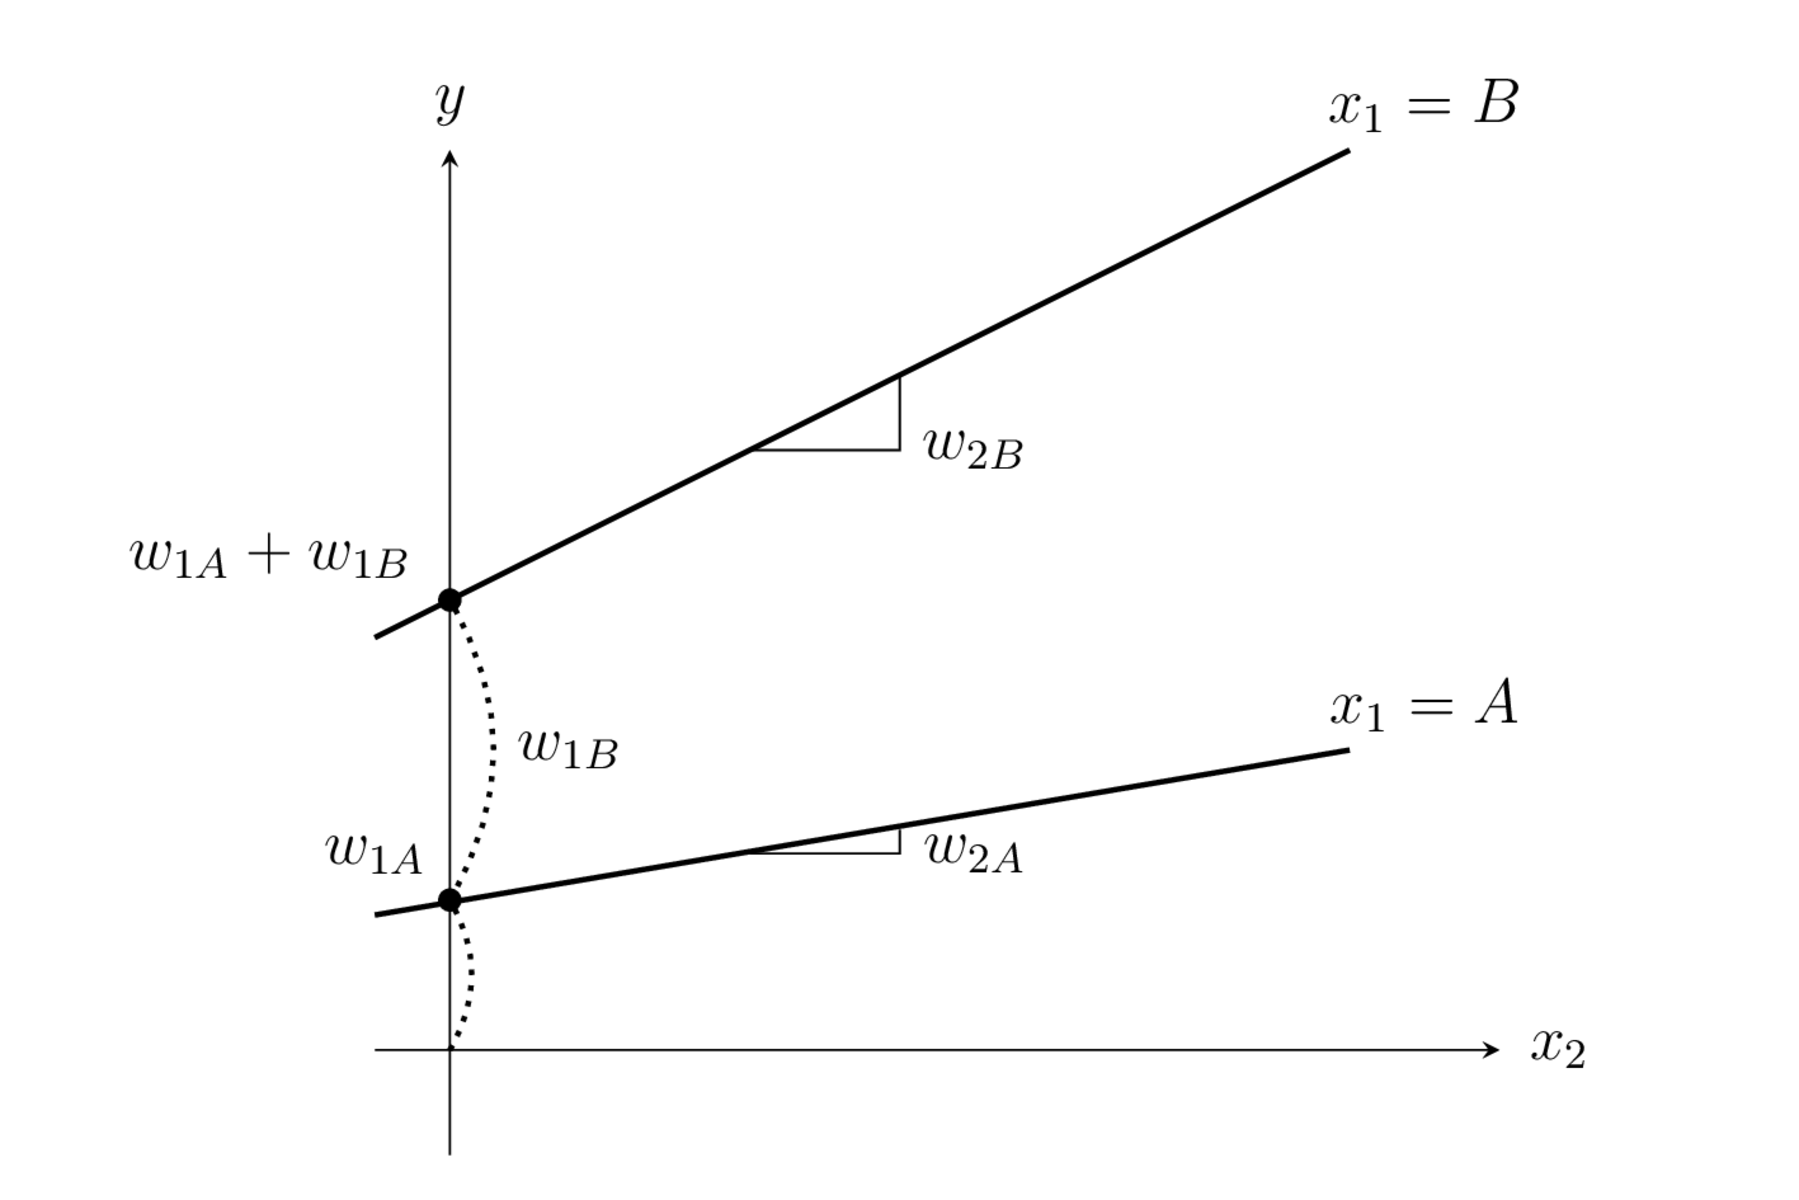

